# Preprocessing

In [37]:
import numpy as np
from PIL import Image
import time

def binarize(grayscale, thresh):
    return np.where(grayscale > thresh, 1, 0)

def get_data_image(filename, bin_thresh=0.85):
    img = Image.open(filename).resize((720, 720)).convert("LA")
    image = np.asarray(img)/256
    binarized = binarize(image, bin_thresh)
    ret_img = binarized[:, :, 0:1]
    return ret_img

start_time = time.time()
pp = get_data_image("detector_alpha_ve_ca_nm/plots/30.png", 0.7)
end_time = time.time()
print("Processing time: %f seconds" % (end_time-start_time))
pp.shape

Processing time: 0.019951 seconds


(720, 720, 1)

# Build model

In [1]:
from keras import layers
from keras import models
from keras import optimizers

def build_model():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(720, 720, 1)))
    model.add(layers.MaxPooling2D((3, 3)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((3, 3)))
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=optimizers.RMSprop(lr=1e-4),
        metrics=['acc']

    )
    return model

def other_build_model():
    model = models.Sequential()
    model.add(layers.Conv2D(16, (3, 3), activation='relu', input_shape=(720, 720, 1)))
    model.add(layers.MaxPooling2D((3, 3)))
    model.add(layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((3, 3)))
    model.add(layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((3, 3)))
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(8))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=optimizers.RMSprop(lr=1e-4),
        metrics=['acc']

    )
    return model

In [2]:
model = other_build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 718, 718, 16)      160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 239, 239, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 237, 237, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 79, 79, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 77, 77, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 25, 25, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 20000)             0

# Training

In [4]:
dir_suffix="ve_va_ym"

In [5]:
import tensorflow as tf
from keras.utils import Sequence

"""Data generator for Keras"""
class DataGenerator(Sequence):
    def __init__(self, list_IDs, labels, batch_size=32, dim=(720,720), n_channels=1,
                 n_classes=None, shuffle=True):
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    """Returns the # of batches per epoch"""
    def __len__(self):
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    """
    Generates a batch of data at a given index
    """
    def __getitem__(self, index):
        # Get indices of batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Get list of IDs to generate data from
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y
    
    """Set indices after epoch to randomize data"""
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    """
    Generate data for a single batch
    """
    def __data_generation(self, list_IDs_temp):
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Load sample
            X[i,] = self.get_data_image(ID)

            # Store class
            y[i] = self.labels[ID]

        return X, y
    
    def binarize(self, grayscale, thresh):
        return np.where(grayscale > thresh, 1, 0)

    def get_data_image(self, filename, bin_thresh=0.85):
        img = Image.open(filename).resize(self.dim).convert("LA")
        image = np.asarray(img)/256
        binarized = self.binarize(image, bin_thresh)
        ret_img = binarized[:, :, 0:1]
        return ret_img

In [6]:
"""Set up training and validation data"""
train_x =  ["detector_alpha_%s/plots/%d.png"     % (dir_suffix, i) for i in range(4000)]
train_x += ["detector_electrons_%s/plots/%d.png" % (dir_suffix, i) for i in range(4000)]
valid_x =  ["detector_alpha_%s/plots/%d.png"     % (dir_suffix, i) for i in range(4000,5000)]
valid_x += ["detector_electrons_%s/plots/%d.png" % (dir_suffix, i) for i in range(4000,5000)]
train_x[500]

'detector_alpha_ve_va_ym/plots/500.png'

In [7]:
train_label_map = {filename : (1 if filename[9:14]=="alpha" else 0) for filename in train_x}
valid_label_map = {filename : (1 if filename[9:14]=="alpha" else 0) for filename in valid_x}

In [8]:
params = {'dim': (720,720),
          'batch_size': 16,
          'n_classes': 1,
          'n_channels': 1,
          'shuffle': True}

# Set up generators
training_generator =   DataGenerator(train_x, train_label_map, **params)
validation_generator = DataGenerator(valid_x, valid_label_map, **params)

In [9]:
# Fit!
model = other_build_model()
history = model.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    verbose=True,
                    epochs=40)

c:\users\ang79722\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/40
500/500 [==============================] - 1029s 2s/step - loss: 0.6825 - acc: 0.5352 - val_loss: 0.5797 - val_acc: 0.6880
Epoch 2/40
500/500 [==============================] - 1106s 2s/step - loss: 0.4871 - acc: 0.7790 - val_loss: 0.2605 - val_acc: 0.9005
Epoch 3/40
500/500 [==============================] - 1016s 2s/step - loss: 0.2179 - acc: 0.9097 - val_loss: 0.1992 - val_acc: 0.9070
Epoch 4/40
500/500 [==============================] - 1030s 2s/step - loss: 0.1643 - acc: 0.9198 - val_loss: 0.1617 - val_acc: 0.9155
Epoch 5/40
500/500 [==============================] - 1032s 2s/step - loss: 0.1472 - acc: 0.9268 - val_loss: 0.1585 - val_acc: 0.9200
Epoch 6/40
500/500 [==============================] - 1022s 2s/step - loss: 0.1372 - acc: 0.9273 - val_loss: 0.1564 - val_acc: 0.9205
Epoch 7/40
500/500 [==============================] - 1022s 2s/step - loss: 0.1343 - acc: 0.9312 - val_loss: 0.1429 - val_acc: 0.9215
Epoch 8/40
500/500 [==============================] - 1036s 2s

In [6]:
history

from keras import layers
from keras import models
from keras import optimizers

def build_model():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(720, 720, 1)))
    model.add(layers.MaxPooling2D((3, 3)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((3, 3)))
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=optimizers.RMSprop(lr=1e-4),
        metrics=['acc']

    )
    return model

def other_build_model():
    model = models.Sequential()
    model.add(layers.Conv2D(16, (3, 3), activation='relu', input_shape=(720, 720, 1)))
    model.add(layers.MaxPooling2D((3, 3)))
    model.add(layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((3, 3)))
    model.add(layer

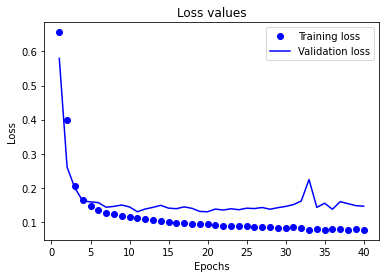

In [27]:
import matplotlib.pyplot as plt

plt.xlabel("Epochs")
plt.ylabel("Loss")
epochs=range(1,len(hist_dict["loss"])+1)
plt.plot(epochs, hist_dict["loss"], "bo", label="Training loss")
plt.plot(epochs, hist_dict["val_loss"], "b", label="Validation loss")
plt.title("Loss values")
plt.legend()
plt.savefig("%s_loss.png" % (dir_suffix))

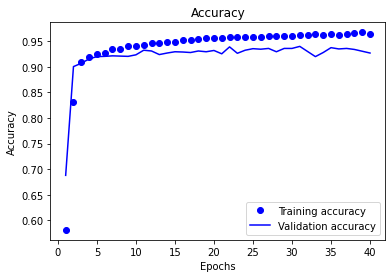

In [26]:
import matplotlib.pyplot as plt

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
epochs=range(1,len(hist_dict["acc"])+1)
plt.plot(epochs, hist_dict["acc"], "bo", label="Training accuracy")
plt.plot(epochs, hist_dict["val_acc"], "b", label="Validation accuracy")
plt.title("Accuracy")
plt.legend()
plt.savefig("%s_accuracy.png" % (dir_suffix))

In [14]:
model.save("ve_va_ym_model.h5")

In [48]:
prediction = model.predict(np.asarray([get_data_image("detector_alpha_%s/plots/4651.png" % (dir_suffix), bin_thresh=0.85)]))

In [49]:
prediction

array([[1.]], dtype=float32)